In [4]:
import os
from os.path import join, isdir, isfile, abspath, dirname, splitext, basename, split

from IPython.display import Markdown, display
from dotenv import load_dotenv
import numpy as np
import pandas as pd

from misc_util.pretty_print import pretty_print as print
from derive_conceptualspace.pipeline import CustomContext, SnakeContext, load_envfiles
from derive_conceptualspace.settings import ENV_PREFIX, get_setting

from misc_util.logutils import setup_logging
from misc_util.pretty_print import display, pretty_print as print
from derive_conceptualspace.util.threedfigure import ThreeDFigure
from derive_conceptualspace.semantic_directions.cluster_names import get_name_dict
from derive_conceptualspace.pipeline import SnakeContext, load_envfiles, cluster_loader
from derive_conceptualspace.util.result_analysis_tools import getfiles_allconfigs
from derive_conceptualspace.util.desc_object import DescriptionList
from derive_conceptualspace.evaluate.shallow_trees import classify_shallowtree

pd.options.display.float_format = '{:.3f}'.format

## Analysis of different "measures of faithfulness of the separation"

In [6]:
setup_logging()
load_envfiles("siddata")
configs, print_cnf = getfiles_allconfigs("featureaxes", verbose=True)

<span style="font-size:11pt">There are 28 different parameter-combis for dataset <span style="color: #0000ff">siddata2022</span>:</span>

{'dataset': 'siddata2022',
 'debug': 'False',
 'embed_dimensions': ['3', '50', '200'],
 'embed_algo': 'mds',
 'quantification_measure': ['ppmi', 'tfidf'],
 'translate_policy': 'onlyorig',
 'dcm_quant_measure': ['count', 'ppmi', 'tfidf'],
 'extraction_method': 'tfidf',
 'language': 'de',
 'pp_components': ['mfauhcsd2', 'mfauhtcsldp'],
 'min_words_per_desc': '80',
 'kappa_weights': 'quadratic'}

<span style="font-size:11pt">conf_file demanded config PP_COMPONENTS to be <span style="color: #ff0000">mfauhcsd2</span>, but force overwrites it to <span style="color: #0000ff">mfauhtcsldp</span></span>

<span style="font-size:11pt">Config-File /home/chris/Documents/UNI_neu/Masterarbeit/Derive_Conceptualspace/config/derrac2015_edited.yml loaded.</span>

<span style="font-size:11pt">Running with the following settings [<span style="color: #ff0000">1841284848</span>]: CLASSIFIER: <span style="color: #0000ff">SVM</span>, CLASSIFIER_SUCCMETRIC: <span style="color: #ff0000">kappa_count2rank_onlypos</span>, DATASET: <span style="color: #ff0000">siddata2022</span>, DCM_QUANT_MEASURE: <span style="color: #0000ff">count</span>, DEBUG: <span style="color: #0000ff">False</span>, EMBED_ALGO: <span style="color: #0000ff">mds</span>, EMBED_DIMENSIONS: <span style="color: #ff0000">3</span>, EXTRACTION_METHOD: <span style="color: #ff0000">tfidf</span>, KAPPA_WEIGHTS: <span style="color: #0000ff">quadratic</span>, LANGUAGE: <span style="color: #0000ff">de</span>, MIN_WORDS_PER_DESC: <span style="color: #ff0000">80</span>, PP_COMPONENTS: <span style="color: #ff0000">mfauhtcsldp</span>, PRIM_LAMBDA: <span style="color: #0000ff">0.5</span>, QUANTIFICATION_MEASURE: <span style="color: #ff0000">ppmi</span>, RANDOM_SEED: <span style="color: #ff0000">None</span>, SEC_LAMBDA: <span style="color: #ff0000">0.2</span>, TRANSLATE_POLICY: <span style="color: #0000ff">onlyorig</span></span>

Counting Occurences [verbose]: 100%|██████████| 9053/9053 [00:39<00:00, 229.55it/s]


<span style="font-size:11pt">Found 9053 candidate Terms, 9053 (100%) of which occur in at least 25 descriptions.</span>

<span style="font-size:11pt">The 25 terms that occur in the most descriptions (incl the #descriptions they occur in): seminar (6268), sollen (5222), sowie (4269), literatur (4257), veranstaltung (3537), studierend (3497), 2 (3263), dabei (3207), geben (3139), thema (3106), frage (2934), erster (2863), stehen (2734), 1 (2714), grundlage (2655), finden (2619), verschieden (2551), neu (2491), eigen (2461), 3 (2331), ziel (2323), teilnahme (2303), text (2295), einfuhrung (2246), inhalt (2156)</span>

<span style="font-size:11pt">Max value: Term <span style="color: #0000ff">nbsp</span> has value <span style="color: #0000ff">469.000</span> for doc <span style="color: #0000ff">Geschichte erleben – Umgang mit Menschen mit Behinderungen während der NS- Zeit B.1 (3)</span></span>

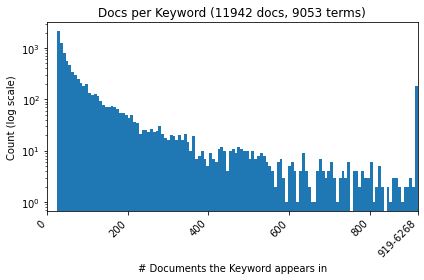

In [7]:
sample_ctx = SnakeContext.loader_context(config=configs[0]) #dict(debug=False, min_words_per_desc=80, dcm_quant_measure="count")
descriptions, dcm, embedding, featureaxes = sample_ctx.load("pp_descriptions", "filtered_dcm", "embedding", "featureaxes")
dcm.show_info(descriptions=descriptions)

In [8]:
%precision %.3f

def show_metrics(featureaxes, metric="kappa_rank2rank_onlypos_min", lamb1=0.5, lamb2=0.1):
    #I'm interested in:
    # *hat bin2bin/f_one ne hohe überschneidung mit anderen guten (kappa_rank2rank_onlypos_min, kappa_digitized_onlypos_2, kappa_count2rank_onlypos)
    # *was sind so die überschneidungen dieser guten 
    all_metrics = list(list(featureaxes["metrics"].values())[0].keys())
    print(all_metrics)
    one_metric = {k: v[metric] for k, v in featureaxes["metrics"].items()}
    one_metric = dict(sorted(one_metric.items(), reverse=True, key=lambda x : float('-inf') if np.isnan(x[1]) else x[1])) #https://stackoverflow.com/q/4240050/5122790
    t1 = {k: v for k, v in one_metric.items() if v >= lamb1}
    t2 = {k: v for k, v in one_metric.items() if v >= lamb2 and k not in t1.keys()}
    print(f"Lamb1: {lamb1} with {len(t1)} entries | Lamb2: {lamb2} with {len(t2)} entries | others: {len(one_metric)-len(t1)-len(t2)}")
    display(t1)
    print("="*50)
    display(t2)

def highlight_nonzero_max(data):
    #df.style.apply(highlight_nonzero_max, axis=0), https://stackoverflow.com/a/62639983/5122790
    #df.style.highlight_max(color='lightgreen', axis=0)
    return [f'font-weight: bold' if v == data.max() and v > 0 else '' for v in data]

def generate_comparertable(metrics, maxval=1.1, minval=0.5):
    all_metrics = list(list(metrics.values())[0].keys())
    t1_permetric = {}
    for metric in all_metrics:
        one_metric = {k: v[metric] for k, v in metrics.items()}
        one_metric = dict(sorted(one_metric.items(), reverse=True, key=lambda x : float('-inf') if np.isnan(x[1]) else x[1])) #https://stackoverflow.com/q/4240050/5122790
        t1 = {k: v for k, v in one_metric.items() if v >= minval and v < maxval}
        t1_permetric[metric] = set(t1.keys())
    t1_table = np.zeros([len(t1_permetric), len(t1_permetric)])
    for n1, k1 in enumerate(t1_permetric.values()):
        for n2, k2 in enumerate(t1_permetric.values()):
            t1_table[n1,n2] = len(k1&k2)/len(k1) if len(k1) > 0 else 0
    columns = [i.replace("kappa", "k").replace("dense", "d").replace("rank2rank", "r2r").replace("count2rank", "c2r").replace("bin2bin", "b2b").replace("f_one", "f1").replace("digitized", "dig").replace("_onlypos", "+") for i in t1_permetric.keys()]
    df = pd.DataFrame(t1_table, columns=columns, index=[f"{i} ({len(list(t1_permetric.values())[n])})" for n, i in enumerate(columns)])
    df.values[tuple([np.arange(df.shape[0])]*2)] = np.nan
    df = df.style.apply(highlight_nonzero_max, axis=1).format(precision=3)
    return df

In [14]:
show_metrics(featureaxes, lamb1=0.3, lamb2=0.05)
#I'm interested in:
# *hat bin2bin/f_one ne hohe überschneidung mit anderen guten (kappa_rank2rank_onlypos_min, kappa_digitized_onlypos_2, kappa_count2rank_onlypos)
# *was sind so die überschneidungen dieser guten 

<span style="font-size:11pt">['accuracy', 'precision', 'recall', 'did_converge', 'f_one', 'kappa_rank2rank_dense', 'kappa_rank2rank_min', 'kappa_bin2bin', 'kappa_digitized', 'kappa_count2rank_onlypos', 'kappa_rank2rank_onlypos_dense', 'kappa_rank2rank_onlypos_min', 'kappa_rank2rank_onlypos_max', 'kappa_digitized_onlypos_2']</span>

<span style="font-size:11pt">Lamb1: 0.3 with 180 entries | Lamb2: 0.05 with 2887 entries | others: 5986</span>

{'lernberatung': 0.675,
 'aktualisieren': 0.630,
 'fallstudie': 0.608,
 '46': 0.608,
 'ungefahr': 0.597,
 'kunz': 0.580,
 'umfang ca': 0.561,
 '20 studierend': 0.557,
 'dem': 0.550,
 '4 sws': 0.536,
 'gelande': 0.530,
 'gi': 0.501,
 'festlegung': 0.499,
 'gefunden': 0.495,
 'denen personlich': 0.486,
 'lehrwerk': 0.480,
 'schuldrecht': 0.479,
 'kurs 2': 0.478,
 '1 4': 0.477,
 'donnerstag 21': 0.473,
 'tutorium beginnen': 0.471,
 'menschenrecht': 0.470,
 'gabriel': 0.470,
 'verwaltungsrecht': 0.467,
 'ende kurs': 0.465,
 'synchron': 0.455,
 'studienordnung': 0.453,
 'semesterhalfte': 0.452,
 'japanisch': 0.450,
 'hartmann': 0.447,
 'tanz': 0.442,
 'geben gelegenheit': 0.442,
 'bescheinigung': 0.438,
 'vorlesungsteil': 0.436,
 'prapositionen': 0.434,
 'teilbereich': 0.433,
 'veranstaltung einfuhrung': 0.431,
 '1 3': 0.431,
 'sozialgeographisch': 0.430,
 'pro semester': 0.430,
 'gy': 0.429,
 'methoden': 0.428,
 'informationsveranstaltung': 0.424,
 'strafrecht': 0.423,
 'schwedisch': 0.421

<span style="font-size:11pt">==================================================</span>

{'gewunscht': 0.300,
 'innen sollen': 0.299,
 'ovid': 0.299,
 'fertigkeit': 0.299,
 'sa': 0.298,
 'semesterbegleitend': 0.297,
 'kunstlerinnen': 0.296,
 'franz ouml': 0.296,
 '2 seminar': 0.296,
 '30': 0.295,
 'menschenwurde': 0.295,
 'berufsbezogen': 0.294,
 '2019': 0.293,
 'geben aumlen': 0.293,
 'werden der': 0.292,
 'vermeidung': 0.292,
 'arbeitgeber': 0.291,
 'schl': 0.291,
 'text verfassen': 0.290,
 'grundrecht': 0.288,
 'boden': 0.288,
 'veranstaltung behandeln': 0.288,
 '00 uhr': 0.287,
 'arm': 0.286,
 'erl auml': 0.286,
 'kap': 0.285,
 'festival': 0.285,
 'wiesbaden springer': 0.285,
 'brox': 0.285,
 'modul': 0.284,
 'betriebswirtschaftlich': 0.284,
 'klausuren': 0.284,
 'tagung': 0.284,
 'diversitat': 0.284,
 'schulpraktikum': 0.282,
 'musikwissenschaft': 0.282,
 'teilnahmevoraussetzung veranstaltung': 0.281,
 'thinking': 0.281,
 'studierend kennen': 0.281,
 'pandemie': 0.281,
 'dienstag': 0.281,
 'lerngruppen': 0.281,
 'ller': 0.281,
 'teilgebieten': 0.280,
 'erl': 0.279,
 '

In [15]:
generate_comparertable(sample_ctx.obj["featureaxes"]["metrics"], minval=0.5)
#look at combis of bin2bin, f_one, k_r2r+_min, k_dig+_2, k_c2r+

,accuracy,precision,recall,did_converge,f1,k_r2r_d,k_r2r_min,k_b2b,k_dig,k_c2r+,k_r2r+_d,k_r2r+_min,k_r2r+_max,k_dig+_2
accuracy (7655),nan,0.001,0.999,0.453,0.002,0.000,0.000,0.001,0.000,0.000,0.000,0.001,0.001,0.000
precision (6),1.000,nan,1.000,1.000,1.000,0.000,0.000,0.500,0.000,0.000,0.000,0.000,0.000,0.000
recall (9045),0.846,0.001,nan,0.406,0.001,0.000,0.000,0.001,0.000,0.000,0.000,0.001,0.001,0.000
did_converge (3675),0.944,0.002,0.999,nan,0.003,0.000,0.000,0.002,0.000,0.000,0.000,0.001,0.000,0.000
f1 (13),1.000,0.462,1.000,0.923,nan,0.000,0.000,0.538,0.000,0.000,0.000,0.000,0.000,0.000
k_r2r_d (0),0.000,0.000,0.000,0.000,0.000,nan,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
k_r2r_min (0),0.000,0.000,0.000,0.000,0.000,0.000,nan,0.000,0.000,0.000,0.000,0.000,0.000,0.000
k_b2b (7),1.000,0.429,1.000,0.857,1.000,0.000,0.000,nan,0.000,0.000,0.000,0.000,0.000,0.000
k_dig (0),0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,nan,0.000,0.000,0.000,0.000,0.000
k_c2r+ (0),0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,nan,0.000,0.000,0.000,0.000


* bin2bin und f1 haben sehr hohe überschneidung (bin2bin ist aber strenger)
* k_r2r+_min and k_dig+_2 have the exact same results
* k_r2r+_min and k_c2r+ don't have too high of an overlap
* ALL of k_r2r+_min/k_dig+_2 (16), k_c2r+ (9) are in b2b
* ALL of the onlypos-statistics are completely in the respective kappa bin2bin

In [16]:
generate_comparertable(sample_ctx.obj["featureaxes"]["metrics"], minval=0.1)

,accuracy,precision,recall,did_converge,f1,k_r2r_d,k_r2r_min,k_b2b,k_dig,k_c2r+,k_r2r+_d,k_r2r+_min,k_r2r+_max,k_dig+_2
accuracy (8500),nan,0.049,1.000,0.429,0.111,0.000,0.010,0.054,0.000,0.001,0.000,0.198,0.065,0.046
precision (420),1.000,nan,1.000,0.721,1.000,0.000,0.200,0.719,0.000,0.000,0.000,0.286,0.138,0.007
recall (9053),0.939,0.046,nan,0.406,0.104,0.000,0.009,0.051,0.000,0.001,0.000,0.201,0.067,0.049
did_converge (3675),0.993,0.082,1.000,nan,0.165,0.000,0.019,0.072,0.000,0.001,0.001,0.188,0.063,0.034
f1 (943),1.000,0.445,1.000,0.642,nan,0.000,0.089,0.488,0.000,0.000,0.000,0.239,0.117,0.007
k_r2r_d (0),0.000,0.000,0.000,0.000,0.000,nan,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
k_r2r_min (84),1.000,1.000,1.000,0.845,1.000,0.000,nan,0.988,0.000,0.000,0.000,0.500,0.333,0.000
k_b2b (460),1.000,0.657,1.000,0.578,1.000,0.000,0.180,nan,0.000,0.000,0.000,0.254,0.172,0.015
k_dig (0),0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,nan,0.000,0.000,0.000,0.000,0.000
k_c2r+ (11),0.909,0.000,1.000,0.364,0.000,0.000,0.000,0.000,0.000,nan,0.364,1.000,1.000,0.636


In [17]:
generate_comparertable(sample_ctx.obj["featureaxes"]["metrics"], minval=0.1, maxval=0.5)

,accuracy,precision,recall,did_converge,f1,k_r2r_d,k_r2r_min,k_b2b,k_dig,k_c2r+,k_r2r+_d,k_r2r+_min,k_r2r+_max,k_dig+_2
accuracy (845),nan,0.000,0.001,0.000,0.001,0.000,0.000,0.000,0.000,0.001,0.000,0.212,0.072,0.084
precision (414),0.000,nan,0.000,0.000,0.983,0.000,0.188,0.705,0.000,0.000,0.000,0.287,0.138,0.007
recall (8),0.125,0.000,nan,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.250,0.000,0.250
did_converge (0),0.000,0.000,0.000,nan,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
f1 (930),0.001,0.438,0.000,0.000,nan,0.000,0.076,0.481,0.000,0.000,0.000,0.240,0.116,0.008
k_r2r_d (0),0.000,0.000,0.000,0.000,0.000,nan,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
k_r2r_min (84),0.000,0.929,0.000,0.000,0.845,0.000,nan,0.905,0.000,0.000,0.000,0.500,0.333,0.000
k_b2b (453),0.000,0.645,0.000,0.000,0.987,0.000,0.168,nan,0.000,0.000,0.000,0.256,0.172,0.015
k_dig (0),0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,nan,0.000,0.000,0.000,0.000,0.000
k_c2r+ (11),0.091,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,nan,0.364,0.727,0.818,0.636
